<a href="https://colab.research.google.com/github/thomas-greig/MSc/blob/main/tau_iso_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Power-law exponents (x from C>0; y from |C|), all r:
  X-axis slopes (30 runs): [-0.9854 -1.1928 -1.4687 -1.6381 -1.1975 -1.1182 -1.4884 -1.6265 -1.3161
 -1.6964 -1.5237 -1.1814 -1.4384 -1.8676 -1.4636 -1.2255 -1.8338 -1.3382
 -1.7173 -1.5046 -1.3082 -1.3395 -1.3758 -1.3883 -1.4517 -1.2157 -1.1615
 -1.7264 -1.2436 -1.2247]
  Y-axis slopes (30 runs, |C_y|): [-1.1314 -0.9525 -1.0871 -1.0665 -0.8102 -0.9287 -0.99   -1.1502 -1.193
 -1.0851 -0.66   -1.1539 -0.8564 -0.8531 -1.2118 -0.8889 -1.3093 -1.0498
 -1.1423 -1.0111 -0.952  -0.9209 -0.9692 -0.9087 -1.0376 -0.977  -1.001
 -0.7673 -1.1675 -1.0612]
  Mean±SD X (all r): -1.4086 ± 0.2227
  Mean±SD Y (|C_y|, all r): -1.0098 ± 0.1438
  Mean R^2 X (all r): 0.6555 | Mean R^2 Y (all r, |C_y|): 0.3706

Restricted-range fits (1 < r < 20):
  X exponents: [-4.0852 -3.7138 -2.1228 -2.0146 -2.0349 -3.9382 -2.5634 -2.0202 -4.292
 -4.0692 -2.0754 -2.2755 -2.6972 -2.3958 -4.2642 -1.4156 -2.1342 -1.1578
 -2.2685 -2.5055 -1.9922 -5.1783 -2.0738 -2.9933 -3.0

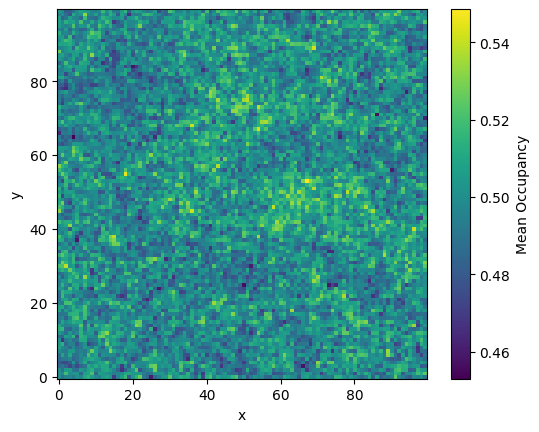

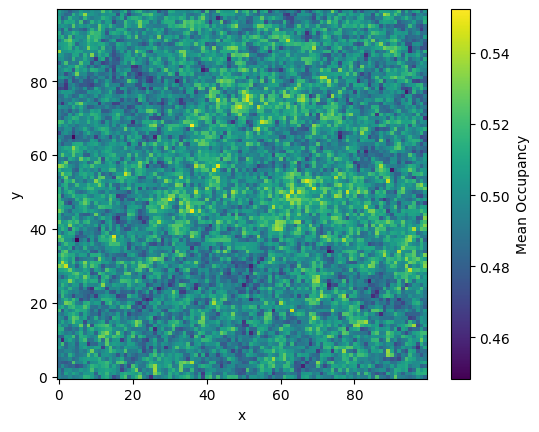

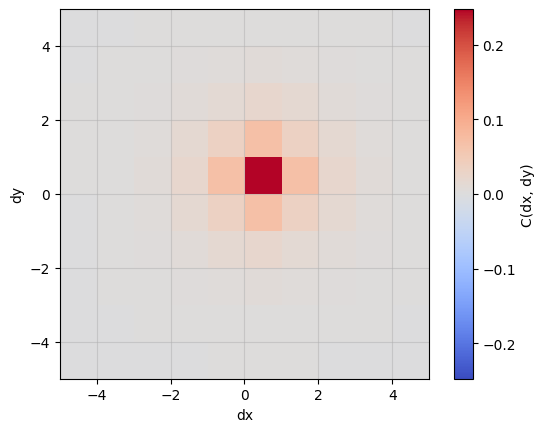

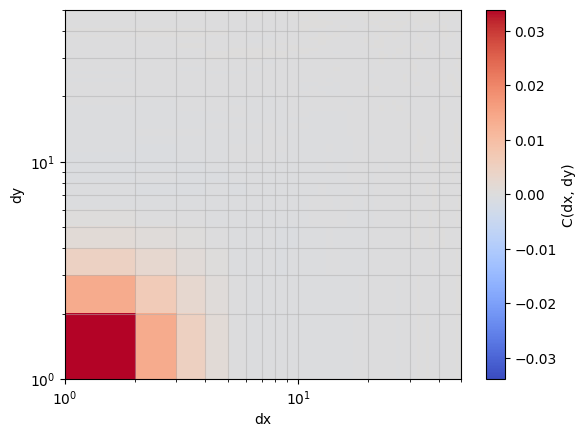

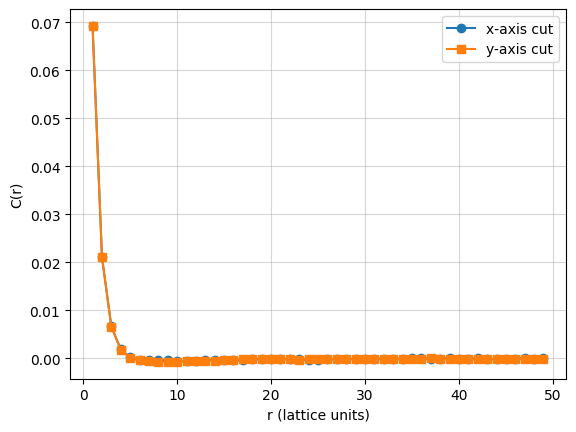

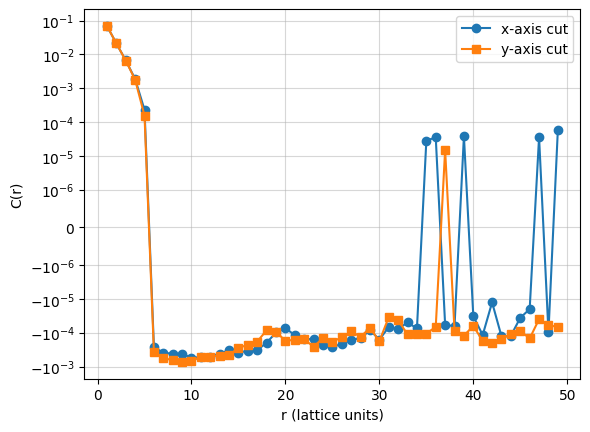

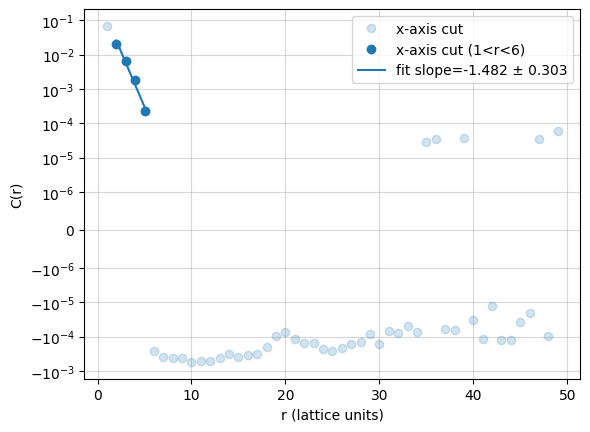

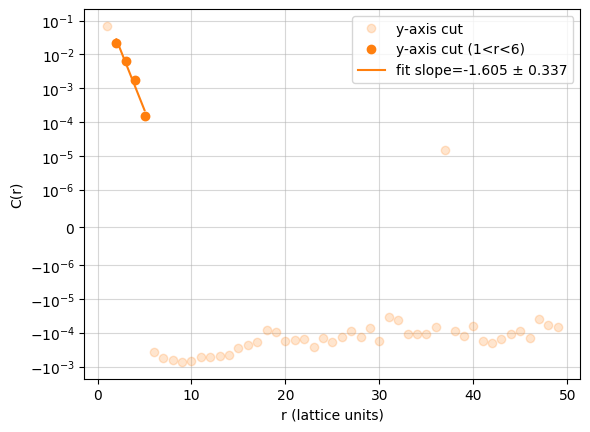

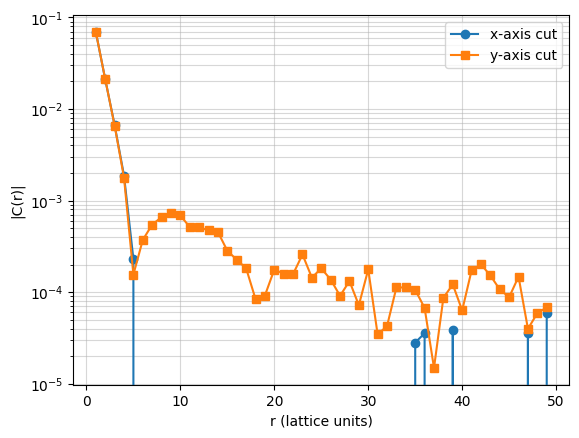

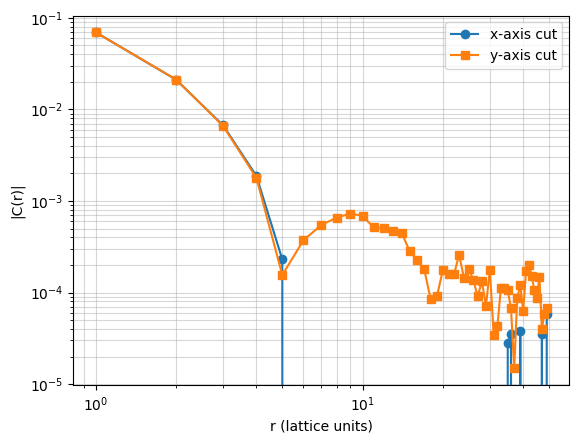

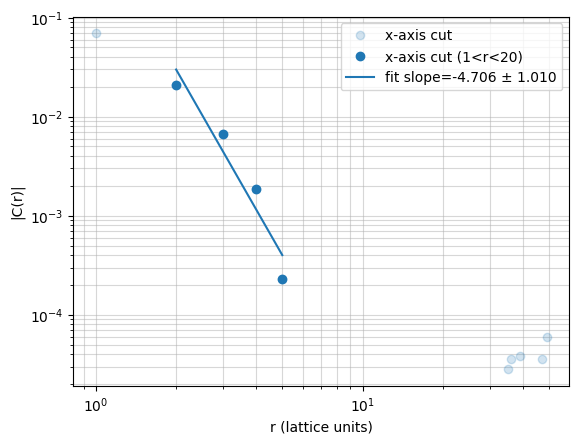

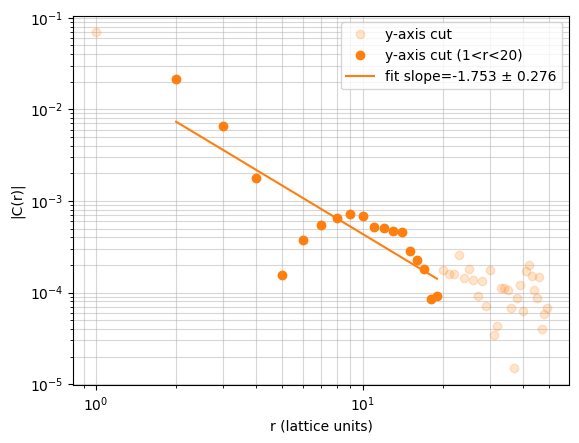

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from numpy.fft import fft2, ifft2, fftshift
from matplotlib.colors import SymLogNorm
from numba import njit  # always use Numba

# =========================
# Global Parameters
# =========================
Lx, Ly = 100, 100
N = 5000
steps = 300_000_000           # total single-particle updates target (N trials ~ 1 sweep)
b_over_T = 3                  # β/T
J_over_T = b_over_T/3.0       # J/T
eps = 0
drift_direction = (0, 0)      # (dx_bias, dy_bias)
sample_every = N*1000
relaxation_index = int(0.2 * steps / sample_every)

runs = 30
base_seed = 52341

# --- τ-leap parameters (no spins) ---
D0 = 1.0                      # base hop rate (sets time units)
dt = 0.99 / (8.0 * D0)        # safe Δt so Σ_m λ_m Δt ≤ 1 (worst case ≤ 8 D0)

# =========================
# Helpers
# =========================
def compute_2D_correlation(data):
    """Streaming FFT accumulation (float32/complex64) to avoid huge temporaries."""
    T, Lx_, Ly_ = data.shape
    mean_n = data.mean(axis=0).astype(np.float32, copy=False)
    corr_fft = np.zeros((Lx_, Ly_), dtype=np.complex64)
    for k in range(T):
        frame32 = data[k].astype(np.float32, copy=False)
        f = np.fft.fft2(frame32 - mean_n)
        corr_fft += f * np.conj(f)
    corr = np.real(np.fft.ifft2(corr_fft)).astype(np.float32, copy=False) / (T * Lx_ * Ly_)
    return fftshift(corr)

def imshow_corr_zoom(corr, window=20, linthresh=1e-6):
    """
    LOG–LOG 2D heatmap over the positive quadrant (dx>0, dy>0).
    Uses log scales on both axes; avoids zero offsets so logs are valid.
    Color scale is linear with symmetric limits.
    """
    Lx_, Ly_ = corr.shape
    cx, cy = Lx_//2, Ly_//2
    h = window//2  # quadrant depth

    sub = corr[cx:cx+h+1, cy:cy+h+1]
    sub = sub[1:, 1:]                 # dx,dy = 1..h

    vmax = np.nanmax(np.abs(sub))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    vmin = -vmax

    plt.figure()
    plt.imshow(
        sub.T, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax,
        extent=[1, h, 1, h], aspect='auto'
    )
    plt.colorbar(label='C(dx, dy)')
    plt.xlabel("dx"); plt.ylabel("dy")
    plt.xscale('log'); plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

def imshow_corr_zoom_linear(corr, window=20):
    """Linear–linear 2D heatmap hard-zoomed to a 10×10 window around the centre."""
    Lx_, Ly_ = corr.shape
    cx, cy = Lx_//2, Ly_//2
    h = 5
    sub = corr[cx-h:cx+h, cy-h:cy+h]
    sub_masked = np.ma.masked_array(sub, mask=False)

    vmax = np.nanmax(np.abs(sub_masked))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    vmin = -vmax

    plt.figure()
    plt.imshow(
        sub_masked.T, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax,
        extent=[-h, h, -h, h]
    )
    plt.colorbar(label='C(dx, dy)')
    plt.xlabel("dx"); plt.ylabel("dy")
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

def directional_cuts(corr_2d):
    """Return r_x, cut_x, r_y, cut_y (cuts from centre toward +x and +y)."""
    Lx_, Ly_ = corr_2d.shape
    cx, cy = Lx_ // 2, Ly_ // 2
    cut_x = corr_2d[cx:, cy]
    cut_y = corr_2d[cx, cy:]
    r_x = np.arange(0, len(cut_x))
    r_y = np.arange(0, len(cut_y))
    return r_x, cut_x, r_y, cut_y

def powerlaw_fit(r, c, r_window=None, use_abs=False, positive_only=False, min_pts=2):
    """Fit log(y) vs log(r) by linear regression."""
    y = np.abs(c) if use_abs else c
    mask = np.isfinite(r) & np.isfinite(y) & (y > 0)
    if r_window is not None:
        rmin, rmax = r_window
        mask &= (r > rmin) & (r < rmax)
    if np.count_nonzero(mask) < min_pts:
        return np.nan, np.nan, np.nan, mask
    lr = np.log(r[mask]); ly = np.log(y[mask])
    slope, intercept, r_value, _, _ = linregress(lr, ly)
    return slope, intercept, r_value**2, mask

# --- Exponential-decay fit (linear in r on log scale) for 1<r<6 ---
def exp_decay_fit(r, c, r_window=(1,6), use_abs=True, min_pts=2):
    """
    Fit ln|c| = a + b * r over r_window.
    Returns (slope b, intercept a, R^2, slope_stderr, mask).
    """
    y = np.abs(c) if use_abs else c
    mask = np.isfinite(r) & np.isfinite(y) & (y > 0)
    if r_window is not None:
        rmin, rmax = r_window
        mask &= (r > rmin) & (r < rmax)
    if np.count_nonzero(mask) < min_pts:
        return np.nan, np.nan, np.nan, np.nan, mask

    lr = r[mask]; ly = np.log(y[mask])
    res = linregress(lr, ly)
    try:
        slope = res.slope
        intercept = res.intercept
        r_value = res.rvalue
        slope_stderr = getattr(res, "stderr", np.nan)
    except AttributeError:
        slope, intercept, r_value, _, slope_stderr = res

    return slope, intercept, r_value**2, slope_stderr, mask

# --- symlog plotting helper to match loglog format ---
def plot_symlog_points_with_exp_fit(r, c, fit_mask, slope, intercept, slope_sd,
                                    pts_label, color, linthresh):
    plt.figure()
    plt.plot(r, c, 'o', alpha=0.2, label=pts_label, color=color)
    plt.plot(r[fit_mask], c[fit_mask], 'o', label=pts_label + ' (1<r<6)', color=color)
    if np.isfinite(slope) and np.isfinite(intercept) and np.count_nonzero(fit_mask) >= 2:
        rr = np.linspace(r[fit_mask].min(), r[fit_mask].max(), 200)
        yy = np.exp(intercept + slope * rr)  # magnitude model (positive)
        label_fit = f"fit slope={slope:.3f} ± {0.0 if not np.isfinite(slope_sd) else slope_sd:.3f}"
        plt.plot(rr, yy, '-', label=label_fit, color=color)
    plt.yscale('symlog', linthresh=linthresh)
    plt.xlabel('r (lattice units)'); plt.ylabel('C(r)')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend(); plt.show()

def plot_loglog_points_with_fit_line(r, c, fit_mask, slope, intercept, slope_sd,
                                     ylabel, pts_label, color):
    plt.figure()
    plt.loglog(r, c, 'o', alpha=0.2, label=pts_label, color=color)
    plt.loglog(r[fit_mask], c[fit_mask], 'o', label=pts_label + ' (1<r<20)', color=color)
    if np.isfinite(slope) and np.isfinite(intercept) and np.count_nonzero(fit_mask) >= 2:
        rr = np.linspace(r[fit_mask].min(), r[fit_mask].max(), 200)
        yy = np.exp(intercept) * rr**slope
        label_fit = f"fit slope={slope:.3f} ± {slope_sd:.3f}"
        plt.loglog(rr, yy, '-', label=label_fit, color=color)
    plt.xlabel('r (lattice units)'); plt.ylabel(ylabel)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend(); plt.show()

def plot_from_corr_2d(corr_2d, restricted_window=(1,20), center_window=100, linthresh=1e-6):
    imshow_corr_zoom_linear(corr_2d, window=center_window)
    imshow_corr_zoom(corr_2d, window=center_window, linthresh=linthresh)

    r_x, cut_x, r_y, cut_y = directional_cuts(corr_2d)
    rx, cx = r_x[1:], cut_x[1:]
    ry, cy_abs = r_y[1:], np.abs(cut_y[1:])
    cy_signed = cut_y[1:]

    # plain linear plot
    plt.figure()
    plt.plot(rx, cx, 'o-', label='x-axis cut', color='C0')
    plt.plot(ry, cy_signed, 's-', label='y-axis cut', color='C1')
    plt.xlabel("r (lattice units)"); plt.ylabel("C(r)")
    plt.grid(True, which="both", ls="-", alpha=0.5); plt.legend(); plt.show()

    # symlog plot (no fits here)
    plt.figure()
    plt.plot(rx, cx, 'o-', label='x-axis cut', color='C0')
    plt.plot(ry, cy_signed, 's-', label='y-axis cut', color='C1')
    plt.yscale('symlog', linthresh=linthresh)
    plt.xlabel("r (lattice units)"); plt.ylabel("C(r)")
    plt.grid(True, which="both", ls="-", alpha=0.5); plt.legend(); plt.show()

    # symlog-format fit plots (use across-run SDs; window 1<r<6)
    bx, ax, r2x_e, bx_se, maskx_e = exp_decay_fit(rx, cx, r_window=(1,6), use_abs=True)
    by, ay, r2y_e, by_se, masky_e = exp_decay_fit(ry, cy_signed, r_window=(1,6), use_abs=True)
    plot_symlog_points_with_exp_fit(rx, cx, maskx_e, bx, ax, std_exp_x_rng, 'x-axis cut', 'C0', linthresh)
    plot_symlog_points_with_exp_fit(ry, cy_signed, masky_e, by, ay, std_exp_y_rng, 'y-axis cut', 'C1', linthresh)

    # semilogy magnitude
    plt.figure()
    plt.semilogy(rx, cx, 'o-', label='x-axis cut', color='C0')
    plt.semilogy(ry, cy_abs, 's-', label='y-axis cut', color='C1')
    plt.xlabel("r (lattice units)"); plt.ylabel("|C(r)|")
    plt.grid(True, which="both", ls="-", alpha=0.5); plt.legend(); plt.show()

    # loglog magnitude
    plt.figure()
    plt.loglog(rx, cx, 'o-', label='x-axis cut', color='C0')
    plt.loglog(ry, cy_abs, 's-', label='y-axis cut', color='C1')
    plt.xlabel("r (lattice units)"); plt.ylabel("|C(r)|")
    plt.grid(True, which="both", ls="-", alpha=0.5); plt.legend(); plt.show()

    # power-law fits (existing)
    sx_fit, ix_fit, _, maskx = powerlaw_fit(rx, cx, r_window=restricted_window, use_abs=False, positive_only=True)
    sy_fit, iy_fit, _, masky = powerlaw_fit(ry, cut_y[1:], r_window=restricted_window, use_abs=True,  positive_only=False)

    plot_loglog_points_with_fit_line(rx, cx, maskx, sx_fit, ix_fit, std_x_rng, '|C(r)|', 'x-axis cut', color='C0')
    plot_loglog_points_with_fit_line(ry, cy_abs, masky, sy_fit, iy_fit, std_y_rng, '|C(r)|', 'y-axis cut', color='C1')

def finite(arr): return arr[np.isfinite(arr)]
def stats(arr):
    a = finite(arr)
    if a.size == 0: return np.nan, np.nan
    return np.mean(a), np.std(a, ddof=1) if a.size > 1 else 0.0

# =========================
# τ-LEAP SIMULATION (Numba)
# =========================
MOVES = np.array([[-1,0],[1,0],[0,1],[0,-1]], dtype=np.int8)  # unused; kept for API compatibility
dx_bias, dy_bias = drift_direction
DRIFT_ALIGN = (MOVES[:,0] * dx_bias + MOVES[:,1] * dy_bias).astype(np.int8)  # unused

@njit
def nn_sum_numba(occ, x, y, Lx, Ly):
    return (occ[(x-1)%Lx,y] + occ[(x+1)%Lx,y] +
            occ[x,(y-1)%Ly] + occ[x,(y+1)%Ly])

@njit
def one_sweep_tau(positions, occupancy, Lx, Ly, b_over_T, J_over_T):
    """
    τ-leap (discrete-time CTMC):
      λ_dir = 2*D0*(1 + eps*Δx_dir) * sigmoid(ΔE),
      p_dir = λ_dir * dt,  p_stay = 1 - Σ p_dir.
    """
    N = positions.shape[0]

    # Random permutation (without replacement) per sweep
    order = np.arange(N)
    for i in range(N-1, 0, -1):
        j = np.random.randint(0, i+1)
        order[i], order[j] = order[j], order[i]

    for t in range(N):
        idx = order[t]
        x0 = positions[idx,0]; y0 = positions[idx,1]

        n0 = occupancy[x0,y0]
        S0 = nn_sum_numba(occupancy, x0, y0, Lx, Ly)

        # RIGHT
        xr, yr = (x0+1)%Lx, y0
        nr = occupancy[xr,yr]; Sr = nn_sum_numba(occupancy, xr, yr, Lx, Ly)
        dE = 2.0*b_over_T*(1.0 + (nr - n0)) - J_over_T*((Sr - S0) - 1.0)
        br = 1.0/(1.0 + np.exp(dE))
        lam_r = 2.0*D0*(1.0 + eps) * br

        # LEFT
        xl, yl = (x0-1)%Lx, y0
        nl = occupancy[xl,yl]; Sl = nn_sum_numba(occupancy, xl, yl, Lx, Ly)
        dE = 2.0*b_over_T*(1.0 + (nl - n0)) - J_over_T*((Sl - S0) - 1.0)
        bl = 1.0/(1.0 + np.exp(dE))
        lam_l = 2.0*D0*(1.0 - eps) * bl

        # UP
        xu, yu = x0, (y0+1)%Ly
        nu = occupancy[xu,yu]; Su = nn_sum_numba(occupancy, xu, yu, Lx, Ly)
        dE = 2.0*b_over_T*(1.0 + (nu - n0)) - J_over_T*((Su - S0) - 1.0)
        bu = 1.0/(1.0 + np.exp(dE))
        lam_u = 2.0*D0*bu

        # DOWN
        xd, yd = x0, (y0-1)%Ly
        nd = occupancy[xd,yd]; Sd = nn_sum_numba(occupancy, xd, yd, Lx, Ly)
        dE = 2.0*b_over_T*(1.0 + (nd - n0)) - J_over_T*((Sd - S0) - 1.0)
        bd = 1.0/(1.0 + np.exp(dE))
        lam_d = 2.0*D0*bd

        # probabilities p = λ Δt; remainder is stay
        pr = lam_r * dt
        pl = lam_l * dt
        pu = lam_u * dt
        pd = lam_d * dt
        psum = pr + pl + pu + pd

        # numerical guard
        if psum > 1.0:
            s = 0.999999 / psum
            pr *= s; pl *= s; pu *= s; pd *= s
            psum = pr + pl + pu + pd

        u = np.random.random()
        if u < pr:
            x1, y1 = (x0+1)%Lx, y0
        elif u < pr + pl:
            x1, y1 = (x0-1)%Lx, y0
        elif u < pr + pl + pu:
            x1, y1 = x0, (y0+1)%Ly
        elif u < psum:
            x1, y1 = x0, (y0-1)%Ly
        else:
            x1, y1 = x0, y0  # stay

        if (x1 != x0) or (y1 != y0):
            positions[idx,0] = x1; positions[idx,1] = y1
            occupancy[x0,y0] -= 1; occupancy[x1,y1] += 1

@njit
def simulate_numba(Lx, Ly, N, steps, sample_every, b_over_T, J_over_T, seed, MOVES, DRIFT_ALIGN):
    if seed >= 0:
        np.random.seed(seed)

    positions = np.empty((N,2), dtype=np.int32)
    positions[:,0] = np.random.randint(0, Lx, size=N)
    positions[:,1] = np.random.randint(0, Ly, size=N)

    occupancy = np.zeros((Lx, Ly), dtype=np.int16)
    for i in range(N):
        occupancy[positions[i,0], positions[i,1]] += 1

    n_samples = steps // sample_every + 1
    series = np.zeros((n_samples, Lx, Ly), dtype=np.int16)
    sidx = 0; series[sidx,:,:] = occupancy; sidx += 1

    step = 0
    # physical time if you care: t = 0.0
    while step < steps:
        one_sweep_tau(positions, occupancy, Lx, Ly, b_over_T, J_over_T)
        step += N
        # t += dt

        while (sidx < n_samples) and (step >= sidx*sample_every):
            series[sidx,:,:] = occupancy
            sidx += 1
            if sidx >= n_samples:
                break
    return series

# =========================
# Per-run stats (no plotting)
# =========================
def compute_run_stats(series, window=(1,20)):
    """
    Returns corr_2d and scalar stats:
      - slope_x_all (C>0, all r)  / slope_y_all_mag (|C|, all r)
      - slope_x_rng (C>0, window) / slope_y_rng_mag (|C|, window)
      - r2_x_all, r2_y_all, r2_x_rng, r2_y_rng
    """
    stationary = series[relaxation_index:]
    corr_2d = compute_2D_correlation(stationary)
    r_x, cut_x, r_y, cut_y = directional_cuts(corr_2d)

    sx_all, _, r2x_all, _ = powerlaw_fit(r_x[1:], cut_x[1:], r_window=None, use_abs=False, positive_only=True)
    sy_all_mag, _, r2y_all, _ = powerlaw_fit(r_y[1:], cut_y[1:], r_window=None, use_abs=True,  positive_only=False)
    sx_rng, _, r2x_rng, _ = powerlaw_fit(r_x[1:], cut_x[1:], r_window=window, use_abs=False, positive_only=True)
    sy_rng_mag, _, r2y_rng, _ = powerlaw_fit(r_y[1:], cut_y[1:], r_window=window, use_abs=True,  positive_only=False)

    return corr_2d, sx_all, sy_all_mag, sx_rng, sy_rng_mag, r2x_all, r2y_all, r2x_rng, r2y_rng

# =========================
# Run X times and aggregate
# =========================
results = []
sum_corr_2d = None
sum_mean_total = np.zeros((Lx, Ly), dtype=np.float64)
sum_mean_stationary = np.zeros((Lx, Ly), dtype=np.float64)

for i in range(runs):
    seed = base_seed + i
    series = simulate_numba(Lx, Ly, N, steps, sample_every, b_over_T, J_over_T, seed, MOVES, DRIFT_ALIGN)

    stationary = series[relaxation_index:]
    mean_total = series.mean(axis=0)
    mean_stationary = stationary.mean(axis=0)

    corr_2d, sx_all, sy_all_mag, sx_rng, sy_rng_mag, r2x_all, r2y_all, r2x_rng, r2y_rng = compute_run_stats(series)
    results.append({
        "slope_x_all": sx_all, "slope_y_all_mag": sy_all_mag,
        "slope_x_rng": sx_rng, "slope_y_rng_mag": sy_rng_mag,
        "r2_x_all": r2x_all, "r2_y_all": r2y_all,
        "r2_x_rng": r2x_rng, "r2_y_rng": r2y_rng
    })

    # per-run exponential slopes for 1<r<6 (for across-run SD on symlog plots)
    r_x, cut_x, r_y, cut_y = directional_cuts(corr_2d)
    bx_run, _, _, _, _ = exp_decay_fit(r_x[1:], cut_x[1:], r_window=(1,6), use_abs=True)
    by_run, _, _, _, _ = exp_decay_fit(r_y[1:], cut_y[1:], r_window=(1,6), use_abs=True)
    results[-1]["exp_x_rng"] = bx_run
    results[-1]["exp_y_rng"] = by_run

    if sum_corr_2d is None:
        sum_corr_2d = np.zeros_like(corr_2d, dtype=np.float64)
    sum_corr_2d += corr_2d
    sum_mean_total += mean_total
    sum_mean_stationary += mean_stationary

# Averages for plotting and reporting
avg_corr_2d = sum_corr_2d / runs
avg_mean_total = sum_mean_total / runs
avg_mean_stationary = sum_mean_stationary / runs

# =========================
# Console report (arrays, means±SD, mean R²)
# =========================
exponents_x_all = np.array([r["slope_x_all"] for r in results], dtype=float)
exponents_y_all_mag = np.array([r["slope_y_all_mag"] for r in results], dtype=float)
exponents_x_rng = np.array([r["slope_x_rng"] for r in results], dtype=float)
exponents_y_rng_mag = np.array([r["slope_y_rng_mag"] for r in results], dtype=float)
r2_x_all_arr = np.array([r["r2_x_all"] for r in results], dtype=float)
r2_y_all_arr = np.array([r["r2_y_all"] for r in results], dtype=float)
r2_x_rng_arr = np.array([r["r2_x_rng"] for r in results], dtype=float)
r2_y_rng_arr = np.array([r["r2_y_rng"] for r in results], dtype=float)

# across-run SDs for exponential slopes (1<r<6)
exp_x_rng_arr = np.array([r.get("exp_x_rng", np.nan) for r in results], dtype=float)
exp_y_rng_arr = np.array([r.get("exp_y_rng", np.nan) for r in results], dtype=float)

def stats_arr(arr):
    a = arr[np.isfinite(arr)]
    if a.size == 0: return np.nan, np.nan
    return np.mean(a), np.std(a, ddof=1) if a.size > 1 else 0.0

mean_x_all, std_x_all = stats_arr(exponents_x_all)
mean_y_all, std_y_all = stats_arr(exponents_y_all_mag)
mean_x_rng, std_x_rng = stats_arr(exponents_x_rng)
mean_y_rng, std_y_rng = stats_arr(exponents_y_rng_mag)
mean_r2x_all, _ = stats_arr(r2_x_all_arr)
mean_r2y_all, _ = stats_arr(r2_y_all_arr)
mean_r2x_rng, _ = stats_arr(r2_x_rng_arr)
mean_r2y_rng, _ = stats_arr(r2_y_rng_arr)

# new: stats for exp slopes
mean_exp_x_rng, std_exp_x_rng = stats_arr(exp_x_rng_arr)
mean_exp_y_rng, std_exp_y_rng = stats_arr(exp_y_rng_arr)

np.set_printoptions(precision=4, suppress=True)

print("Power-law exponents (x from C>0; y from |C|), all r:")
print(f"  X-axis slopes ({runs} runs): {exponents_x_all}")
print(f"  Y-axis slopes ({runs} runs, |C_y|): {exponents_y_all_mag}")
print(f"  Mean±SD X (all r): {mean_x_all:.4f} ± {std_x_all:.4f}")
print(f"  Mean±SD Y (|C_y|, all r): {mean_y_all:.4f} ± {std_y_all:.4f}")
print(f"  Mean R^2 X (all r): {mean_r2x_all:.4f} | Mean R^2 Y (all r, |C_y|): {mean_r2y_all:.4f}")

print("\nRestricted-range fits (1 < r < 20):")
print(f"  X exponents: {exponents_x_rng}")
print(f"  Y exponents (|C_y|): {exponents_y_rng_mag}")
print(f"  Mean±SD X (range): {mean_x_rng:.4f} ± {std_x_rng:.4f}")
print(f"  Mean±SD Y (range, |C_y|): {mean_y_rng:.4f} ± {std_y_rng:.4f}")
print(f"  Mean R^2 X (range): {mean_r2x_rng:.4f} | Mean R^2 Y (range): {mean_r2y_rng:.4f}")

# =========================
# Plots (no titles)
# =========================
plt.figure()
plt.imshow(avg_mean_total.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
plt.xlabel("x"); plt.ylabel("y"); plt.show()

plt.figure()
plt.imshow(avg_mean_stationary.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
plt.xlabel("x"); plt.ylabel("y"); plt.show()

# Make ensemble SDs visible to the plotting util (used in legend text)
plot_from_corr_2d.__globals__['std_x_rng'] = std_x_rng
plot_from_corr_2d.__globals__['std_y_rng'] = std_y_rng
plot_from_corr_2d.__globals__['std_exp_x_rng'] = std_exp_x_rng
plot_from_corr_2d.__globals__['std_exp_y_rng'] = std_exp_y_rng

plot_from_corr_2d(
    avg_corr_2d,
    restricted_window=(1,20),
    center_window=100,
    linthresh=1e-6
)
